<h1><center><font size="25">Forecasting series temporales con Python y Scikit-learn</font></center></h1>

<center><b>Joaquín Amat Rodrigo</b></center>

<center><i>Febrero, 2021 (última actualización Diciembre 2021)</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [Predicción (forecasting) de visitas a página web con machine learning](https://www.cienciadedatos.net/documentos/py37-forecasting-visitas-web-machine-learningn.html)
+ [skforecast](https://joaquinamatrodrigo.github.io/skforecast/)

## Introducción
<br>

Una [serie temporal](https://es.wikipedia.org/wiki/Serie_temporal) (*time series*) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de [*Forecasting*](https://en.wikipedia.org/wiki/Forecasting) consiste en predecir el valor futuro de una serie temporal, bien modelando la serie temporal únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas a la serie temporal.

A lo largo de este documento, se describe cómo utilizar modelos de regresión de **Scikit-learn** para realizar *forecasting* sobre series temporales. En concreto, se hace uso de [**Skforecast v0.4**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html), una librería sencilla que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresón de **Scikit-learn** a problemas de *forecasting*. Para un caso de uso más detallado visitar [predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html).
<br><br>

## Multi-Step Time Series Forecasting
<br>

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ($t_{+1}$), sino todo un intervalo futuro o un punto alejado en el tiempo ($t_{+n}$). A cada paso de predicción se le conoce como *step*.

 Existen varias estrategias que permiten generar este tipo de predicciones múltiples.
<br><br>

**Recursive multi-step forecasting**
<br>

Dado que, para predecir el momento $t_{n}$ se necesita el valor de $t_{n-1}$, y $t_{n-1}$ se desconoce, es necesario hacer predicciones recursivas en las que, cada nueva predicción, se basa en la predicción anterior. A este proceso se le conoce como *recursive forecasting* o *recursive multi-step forecasting*.

<div>
<img src='./images/forecasting_multi-step.gif' width="600"/>
</div>

La principal adaptación que se necesita hacer para aplicar modelos de [Scikit-learn](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html) a problemas de *recursive multi-step forecasting* es transformar la serie temporal
en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le preceden. Esta estrategia de *forecasting* pueden generarse fácilmente con las clases `ForecasterAutoreg` y `ForecasterAutoregCustom` de la librería **Skforecast**.

<img src="./images/transform_timeseries.gif" style="width: 550px;">

<center><font size='2.5'> <i>Tranformación de una serie temporal en una matriz de 5 lags y un vector con el valor de la serie que sigue a cada fila de la matriz.</i></font></center>

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.

<img src="./images/matrix_transformation_with_exog_variable.png" style="width: 550px;">

<center><font size='2.5'> <i>Transformación de una serie temporal junto con una variable exógena.</i></font></center>

**Direct multi-step forecasting**
<br>

El método *direct multi-step forecasting* consiste en entrenar un modelo distinto para cada *step*. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada *step*. Como resultado, las predicciones son independientes unas de otras. 

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase `ForecasterAutoregMultiOutput` de la librería **Skforecast**. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas. 

<img src="./images/diagram_skforecast_multioutput.png" style="width: 900px;">

<center><font size='2.5'> <i>Transformación de una serie temporal en en las  matrices necesarias para entrenar un modelo direct multi-step forecasting.</i></font></center>
    
<br><br>

**Multiple output forecasting**
<br>

Determinados modelos son capaces de predecir de forma simultánea varios valores de una secuencia (*one-shot*). Un ejemplo de modelo con esta capacidad son las redes neuronales LSTM.
<br><br>

## Forecasting autorregresivo recursivo
<br>

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.
<br>

### Librerías
<br>

Las librerías utilizadas en este documento son:

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

Además de las anteriores, se utiliza [**Skforecast v0.4**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html), una librería sencilla que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresón de **Scikit-learn** a problemas de *forecasting*. Puede instalarse de las siguientes formas:

`pip install skforecast`

Última versión (inestable):

`pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master`

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

### Datos
<br>

Los datos empleados en los ejemplos de este documento se han obtenido del magnífico libro [Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [3]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

La columna *fecha* se ha almacenado como `string`. Para convertirla en `datetime`, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de **pandas**, se establece como índice. Además, dado que los datos son mensuales, se indica la frecuencia (*Monthly Started 'MS'*).

In [4]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

Se verifica que la serie temporal está completa.

In [5]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [6]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

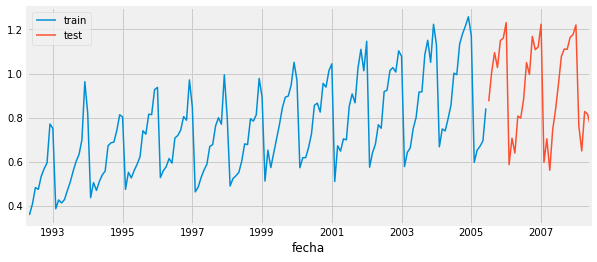

In [7]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg
<br>

Se crea y entrena un modelo `ForecasterAutoreg` a partir de un regresor `RandomForestRegressor` y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [8]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=[1, 5, 6]
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-03 15:58:49 
Last fit date: 2021-12-03 15:58:49 
Skforecast version: 0.4.dev 

### Predicciones
<br>

Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).

In [9]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2005-07-01    0.833803
2005-08-01    0.874866
2005-09-01    0.977970
2005-10-01    0.888383
2005-11-01    0.715608
Freq: MS, Name: pred, dtype: float64

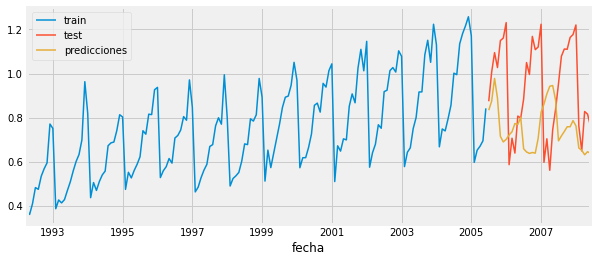

In [10]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test
<br>

Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el *mean squared error (mse)*.

In [11]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.09232216292559114


### Ajuste de hiperparámetros (*tuning*)
<br>

El `ForecasterAutoreg` entrenado ha utilizado una ventana temporal de 6 lags y un modelo [Random Forest](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html) con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de lags e hiperparámetros, la librería **Skforecast** dispone de la función `grid_search_forecaster` con la que comparar los resultados obtenidos con cada configuración del modelo.

<span style="color:red"> comentar que se utiliza una estrategia de backtesting para el gridsearch con o sin refit según el argumento `refit=True` y que esta explicado con más detalle abajo</span>

In [12]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 10,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 2/2 [00:54<00:00, 27.03s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  params: {'max_depth': 3, 'n_estimators': 500}



In [13]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.008055,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.008220,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.008326,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.008330,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.008336,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.008359,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.028249,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.028386,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.028830,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.028883,3,100


<span style="color:red"> Lo comentado si merece la pena poner una columna en este dataframe que sea número de lagas utilizados. Imaginate que se compara 16, 17, 18, 19 y 20. Otra opción es poner la opción de pandas de mostrar todo el contenido de la columna </span>

Los mejores resultados se obtienen si se utiliza una ventana temporal de 20 lags y una configuración de *Random Forest* {'max_depth': 3, 'n_estimators': 500}.

### Modelo final
<br> 

Finalmente, se entrena de nuevo un `ForecasterAutoreg` con la configuración óptima encontrada mediante validación. Este paso no es necesario si se indica `return_best = True` en la función `grid_search_forecaster()`.

In [14]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['y'])

In [15]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

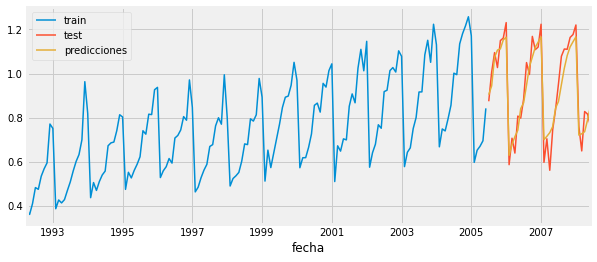

In [16]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [17]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004392699665157793


Con la combinación óptima de hiperparámetros se consigue reducir notablemente el error de test.
<br><br>

### Backtesting
<br>

<span style="color:red"> Poner enlace en la palabra "Backtesting" a la docu? Si es cierto que si es 0.4 aun no hay...</span>

El proceso de *Backtesting* consiste en simular el comportamiento que habría tenido el modelo si se hubiese ido ejecutando de forma recurrente, por ejemplo, prediciendo un total de 9 años a intervalos de 3 años (36 meses). Este tipo de evaluación puede aplicarse fácilmente con la función `backtesting_forecaster()`.

**Backtesting con reentrenamiento (refit)**

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de *cross-validation* en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de forma secuencial, manteniendo el orden temporal de los datos.

<img src="./images/diagram-backtesting-refit.png" style="width: 500px;"/>

<center><font size='2.5'> <i>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y reentrenamiento en cada iteración.</i></font></center>


**Backtesting sin reentrenamiento**

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. <span style="color:red">Esta estrategia tiene la ventaja de ser mucho más rápida que puesto que el modelo solo se entrena una vez</span>. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

<img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"/>

<br>

<center><font size='2.5'> <i>Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps, sin reentrenamiento en cada iteración.</i></font></center>


Independientemente de la estrategia utilizada, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de *overfitting*.

Para este ejemplo, se sigue una estrategia de *backtesting* con reentrenamiento. Internamente, el proceso seguido por la función es:

+ En la primera iteración se emplea el 50% de las observaciones entrenamiento (en este caso 87) para el entrenamiento inicial y las siguientes 36 observaciones como conjunto de validación.

+  En la segunda iteración, se reentrena el modelo añadiendo, al conjunto de entrenamiento inicial, las 36 observaciones de validación anteriores y utilizando las siguientes 36 como el nuevo conjunto de validación.

+ Este proceso se repite hasta que se utilizan todas las observaciones disponibles en la partición de entrenamiento <span style="color:red"> yo aqui pondría entrenamiento-validación</span>. Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como se están prediciendo.

In [18]:
# Backtesting
# ==============================================================================
n_test = 36*3 # Se separan para el backtest los últimos 9 años
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36 # Se utilizan folds de 3 años (36 meses)
forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=15)

metric, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = datos['y'],
                                    initial_train_size = len(datos_train),
                                    steps      = steps,
                                    refit      = True,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

print(f"Error de backtest: {metric}")

Number of observations used for training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
Error de backtest: [0.01210078]


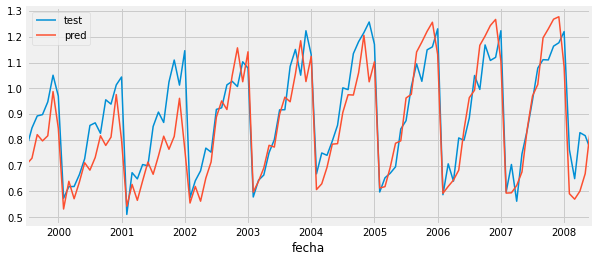

In [19]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

### Importancia predictores
<br>

Dado que el objeto `ForecasterAutoreg` utiliza modelos *scikit-learn*, una vez entrenado, se puede acceder a la importancia de los predictores. Cuando el regresor empleado es un `LinearRegression`, `Lasso` o `Ridge`, la importancia queda reflejada en los [coeficientes](https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html#Interpretaci%C3%B3n-del-modelo) del modelo, que se obtienen con el método `get_coef()`. En regresores  `GradientBoostingRegressor`, `RandomForestRegressor` o `HistGradientBoostingRegressor`, la importancia de los predictores está basada en la [reducción de impureza](https://www.cienciadedatos.net/documentos/py08_random_forest_python.html#Importancia-de-los-predictores) y es accesible mediante el método `get_feature_importance()`.

In [20]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

/home/ximo/anaconda3/envs/cienciadedatos/lib/python3.7/site-packages/skforecast/ForecasterAutoreg/ForecasterAutoreg.py:937: UserWarning: `get_feature_importance` only valid for forecasters with regressor of type (<class 'sklearn.ensemble._forest.RandomForestRegressor'>, <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>).
  f"`get_feature_importance` only valid for forecasters with "


## Forecasting autorregresivo recursivo con variables exógenas
<br>

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. En ciertos escenarios, es posible disponer de información sobre otras variables, **cuyo valor a futuro se conoce**, y pueden servir como predictoreres adicionales en el  modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. Esto mísmo es aplicable a múltiples variables exógenas.
<br><br>

### Datos

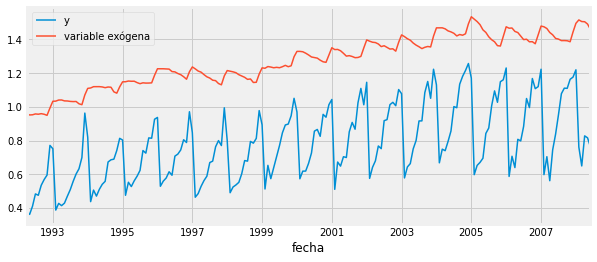

In [21]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [22]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

### ForecasterAutoreg

In [23]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )
forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-03 15:59:47 
Last fit date: 2021-12-03 15:59:47 
Skforecast version: 0.4.dev 

### Predicciones
<br>

Si el `ForecasterAutoreg` se entrena con una variable exógena, hay que pasarle el valor de esta variable al `predict()`. Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [24]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

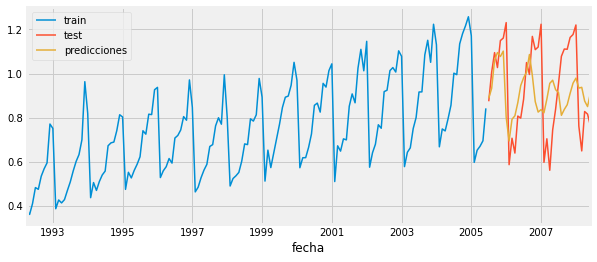

In [25]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test

In [26]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03989087922533575


### Tuning del modelo

In [27]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        exog        = datos_train['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 27


loop lags_grid: 100%|█████████████████████████████| 3/3 [01:15<00:00, 25.02s/it]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  params: {'max_depth': 3, 'n_estimators': 50}



In [28]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.007815,3,50
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",0.007940,5,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.007944,3,500
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.008057,3,100
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.008106,10,100


Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Random Forest {'max_depth': 3, 'n_estimators': 50}.

### Modelo final
<br>

Como se ha indicado `return_best=True` en el `grid_search_forecaster()`, tras la búsqueda, el objeto `ForecasterAutoreg` ha sido modificado y entrenado con la mejor combinación encontrada.

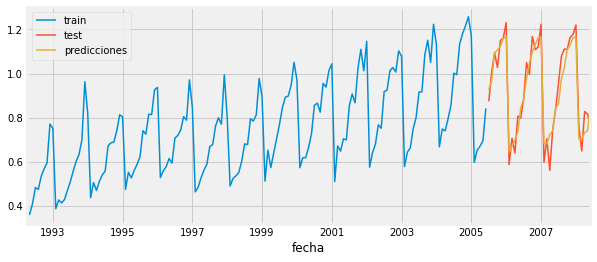

In [29]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [30]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.003965444559763559


## Forecasting autorregresivo recursivo con predictores custom
<br>

En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos *n* valores puede servir para  capturar la tendencia de la serie.

La clase `ForecasterAutoregCustom` se comporta de forma muy similar a la clase `ForecasterAutoreg` vista en los apartados anteriores pero con la diferencia de que, es el usuario, quien define la función empleada para crear los predictores.

Se repite el primer ejemplo del documento, predecir los últimos 36 meses de la serie temporal, pero esta vez, utilizando como predictores los 10 primeros lags y la media móvil de los últimos 20 meses.
<br><br>

### Datos

In [31]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

### ForecasterAutoregCustom
<br>

Se crea y entrena un `ForecasterAutoregCustom` a partir de un regresor `RandomForestRegressor`. Para crear los predictores, se emplea la función `create_predictors()` que calcula los primeros 10 lags y la media móvil de los últimos 20 valores.

In [32]:
# Función para calcular los predictores a partir de la serie temporal
# ==============================================================================
def create_predictors(y):
    '''
    Crear los primeros 10 lags.
    Calcular la media móvil de los últimos 20 valores.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

Al crear el forecaster, el argumento `window_size` debe ser un valor, como mínimo, tan grande como la ventana que utiliza la función que crea los predictores. En este caso 20.

<span style="color:red"> Aquí pondría el ejemplo de llamar al método que te muestra la matriz que crea el forecaster para el entrenamiento. Al usuario seguro que le interesa saber que haya hecho su función correctamente</span>

In [33]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = create_predictors,
                window_size    = 20
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-03 16:01:03 
Last fit date: 2021-12-03 16:01:04 
Skforecast version: 0.4.dev 

### Predicciones

In [34]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)

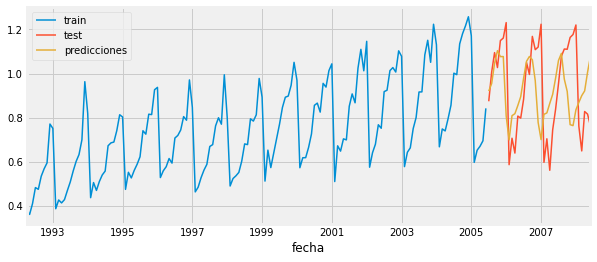

In [35]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test

In [36]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.046232546768232


### Ajuste de hiperparámetros (*tuning*)
<br>

Al utilizar la función `grid_search_forecaster()` con un `ForecasterAutoregCustom`, no se indica el argumento `lags_grid`.

In [37]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = create_predictors,
                window_size    = 20
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        param_grid  = param_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 6


loop lags_grid: 100%|█████████████████████████████| 1/1 [00:46<00:00, 46.75s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: custom predictors 
  params: {'max_depth': 10, 'n_estimators': 100}



In [38]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.028065,10,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",0.028362,10,500
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",0.028834,5,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.028935,5,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",0.031041,3,500
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.031537,3,100


### Modelo final

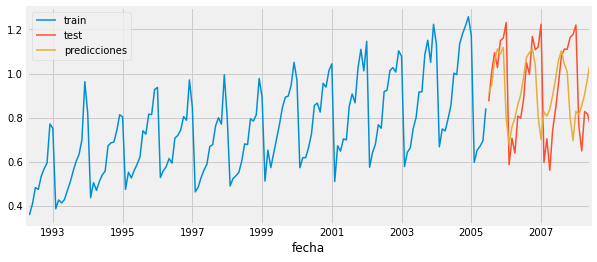

In [39]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [40]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.04303681771042639


## Direct multi-step forecasting
<br>

Para conseguir predicciones a varios *steps* a futuro, los modelos `ForecasterAutoreg` y `ForecasterAutoregCustom` siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los *steps* que se desea predecir. Esta estrategia, normalmente conocida como *direct multi-step forecasting*, es computacionalmente más costosa que la recursiva puesto que requiere entrenar varios modelos. Sin embargo, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase `ForecasterAutoregMultiOutput` y pueden incluir también una o múltiples variables exógenas.
<br><br>


### ForecasterAutoregMultiOutput
<br>

A diferencia de cuando se utiliza `ForecasterAutoreg` o `ForecasterAutoregCustom`, en los modelos de tipo `ForecasterAutoregMultiOutput` hay que indicar, en el momento de su creación, el número de *steps* que se quieren predecir. No es posible predecir *steps* más allá del valor definido en su creación.

Para este ejemplo, se utiliza como regresor un modelo lineal con penalización de [Lasso](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html#Lasso). Estos modelos requieren que los predictores se estandaricen, por lo que se combina con un `StandardScaler` utilizando un [Pipeline](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html#Pipeline-y-ColumnTransformer).

In [41]:
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 36,
                    lags      = 8
                )
forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))]) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'lasso__alpha': 1.0, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__normalize': 'deprecated', 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 123, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False} 
Creation date: 2021-12-03 16:01:53 
Last fit date: None 
Skforecast version: 0.4.dev 

Para acceder a los parámetros de un pipeline de scikitlearn hay que seguir el patrón: \<nombre del componente>__\<nombre del parámetro>.

<span style="color:red">Aqui no me sale el nombre del parámetro, igual es porque me falta algún archivo</span>

In [42]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                steps     = 36,
                lags      = 8 # Este valor será remplazado en el grid search
             )

param_grid = {'lasso__alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 36,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 30


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]

Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  params: {'lasso__alpha': 0.021544346900318846}



In [43]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,lasso__alpha
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'lasso__alpha': 0.021544346900318846},0.010608,0.021544
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.021544346900318846},0.012005,0.021544
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.0016681005372000592},0.013960,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.0001291549665014884},0.014614,0.000129
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 1e-05},0.014648,0.000010


Los mejores resultados se obtienen utilizando una ventana temporal de 20 lags y una configuración de Lasso {'alpha': 0.0215}.

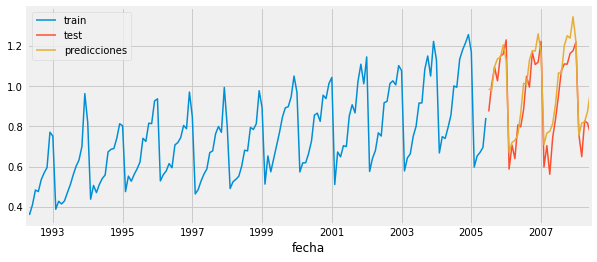

In [44]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [46]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.009726551142140267


## Intervalos de predicción
<br>

Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de $y$ con una determinada probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro *Forecasting: Principles and Practice* [mútiples formas de estimar intervalos de predicción](https://otexts.com/fpp2/prediction-intervals.html), la mayoría los cuales requieren que los resudios (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a *bootstrapping*, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería **Skforecast** para los modelos de tipo `ForecasterAutoreg` y `ForecasterAutoregCustom`.
<br><br>

<span style="color:red"> Explicar que representa el parámetro interval? Es una lista [1, 99]. Yo no termino de enetender que representa</span>

In [47]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

In [48]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
                )

forecaster.fit(y=datos_train['y'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 1000
              )
predicciones.head(5)

,pred,lower_bound,upper_bound
2005-07-01,0.962317,0.812398,1.079511
2005-08-01,0.976595,0.824244,1.095580
2005-09-01,1.140783,0.952218,1.262239
2005-10-01,1.179538,1.020468,1.305193
2005-11-01,1.221138,1.047769,1.354772


Error de test (mse): 0.012100781904923363


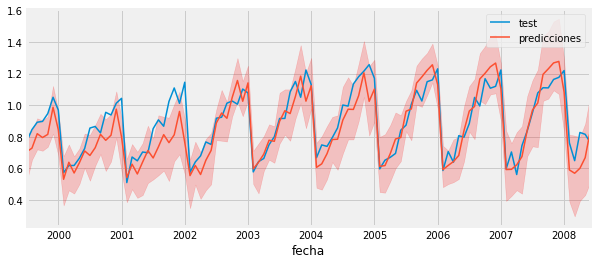

In [60]:
# Error de predicción
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones['pred']
            )
print(f"Error de test (mse): {error_mse}")

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_test['y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

Number of observations used for training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
Error de test (mse): [0.01210078]


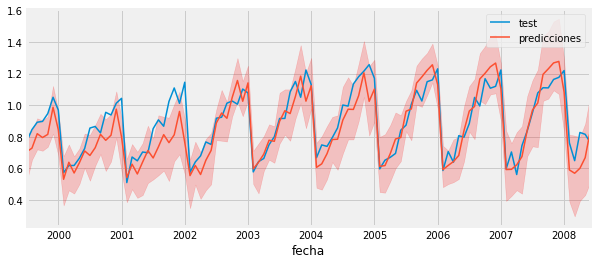

In [61]:
# Backtest con intervalos de predicción
# ==============================================================================
n_test = 36*3
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
forecaster = ForecasterAutoreg(regressor=LinearRegression(), lags=15)

metric, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['y'],
                            initial_train_size = len(datos_train),
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                       )

print(f"Error de test (mse): {metric}")

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_test['y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

## Cargar y guardar modelos
<br>

Los modelos generados con [**Skforecast**](https://joaquinamatrodrigo.github.io/skforecast/) se pueden cargar y guardar usando las librerías **pickle** o **joblib**. A continuación se muestra un ejemplo sencillo utilizando **joblib**.

In [51]:
# Crear forecaster
forecaster = ForecasterAutoreg(LinearRegression(), lags=3)
forecaster.fit(y=datos_train['y'])
forecaster.predict(steps=3)

1999-07-01    0.692493
1999-08-01    0.672130
1999-09-01    0.661185
Freq: MS, Name: pred, dtype: float64

In [52]:
# Guardar modelo
dump(forecaster, filename='forecaster.py')

['forecaster.py']

In [53]:
# Cargar modelo
forecaster_cargado = load('forecaster.py')

In [54]:
# Predicciones
forecaster_cargado.predict(steps=3)

1999-07-01    0.692493
1999-08-01    0.672130
1999-09-01    0.661185
Freq: MS, Name: pred, dtype: float64

## Información de sesión

In [55]:
import session_info
session_info.show(html=False)

-----
ipykernel           6.2.0
joblib              1.0.1
matplotlib          3.4.3
numpy               1.19.5
pandas              1.2.5
session_info        1.0.0
skforecast          0.4.dev
sklearn             1.0.1
-----
IPython             7.26.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-41-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-12-03 16:02


## Bibliografía
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [libro](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [libro](https://openforecast.org/adam/)

Python Data Science Handbook by Jake VanderPlas [libro](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83)

Python for Finance: Mastering Data-Driven Finance [libro](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

[**skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html)

In [56]:
%%html
<style>
.text_cell_render p {
    text-align: justify;
    font-family: 'Open Sans','Helvetica Neue',Helvetica,Arial,sans-serif;
    #font-size: 16px;
    line-height: 1.5;
    font-weight: 400;
    text-shadow: none;
    color: #333333;
    text-rendering: optimizeLegibility;
    letter-spacing: +0.1px;
    margin-bottom: 1.15rem;
    font-size: 1.15em
}

#notebook-container {
    background-color: #fcfcfc;
}

div.inner_cell {
    margin-right: 5%;
}

.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
}

.rendered_html code {
    background-color: #f2f2f2;
    font-family: monospace;
    color: #a20505;
    font-size: 15px;
    #font-size: 1em;
    padding: 1px 1px;
    border: solid;
    border-color: darkgray;
    border-width: thin;
}

.rendered_html h1 {
    padding-top: 50px;
}

.rendered_html h2 {
    font-size: 30px
    margin-top: 0;
    font-size: 2.488em;
}

.rendered_html h3 {
    font-size: 25px;
}

.rendered_html h4 {
    font-size: 20px;
}

</style>

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting series temporales con Python y Scikitlearn by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.